Create csv for each glacier that hold glacier-specific water cover info.
- rgi_id
- o1region
- o2region
- water in each month within set distance bands

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025") \
            .sort_values('o2region', ascending=False)

In [20]:
# process each glacier
c=0
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>1: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    if rgi_id != "RGI2000-v7.0-G-15-06758": continue
    
    # print progress
    if c%10==1: print(c, "of", len(rgi_gdf), rgi_id)
    
    # open glacier mask, debris mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
    xr_gmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_gmask = xr_gmask.where(xr_gmask==1)
    xr_dmask = xr_dmask.where(xr_dmask==1)
    
    # open glacier distances
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_distances.tif')
    xr_distance = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    max_distance = np.nanmax(xr_distance)
    
    # calculate water, total area, in each 100-m band
    bands = np.arange(0,max_distance+1,100)
    
    # open water data, mask to debris
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water',
                             'glacier_water_frequency_monthly0011_188_accaqa.tif') #188 137
    xr_water = riox.open_rasterio(path_open, masked=False).astype(float)
    
    # rename bands to the months which they represent
    xr_water = xr_water.rename({"band":"month"})
    xr_water['month'] = [int(i) for i in list(xr_water.long_name)]
    xr_water = xr_water*xr_dmask
    
    # set 255 to nan
    xr_water = xr_water.where(xr_water<200,np.nan)
    
    # set<0.1 to 0
    xr_water = xr_water.where(xr_water>=0.1,0)
    
    # for each band, calculate water in each year
    all_df = []
    all_areas = []
    all_bands = []
    for i in range(len(bands)-1):
        bmin = int(bands[i])
        bmax = int(bands[i+1])
        bname = f'{bmin}_{bmax}'
        # create mask for this band
        b_mask = xr.where( (xr_distance>=bmin) & (xr_distance<bmax), 1, 0)
        
        # mask water to this band, sum for each month
        water_mask = (xr_water.where(b_mask==1, 0)*900).sum(dim=('x','y')).astype(int) \
                                .to_dataframe(bname).drop('spatial_ref', axis=1)
        
        # add values to list
        all_df.append(water_mask)
        
        # also calculate total area in this band
        all_areas.append(int(np.nansum(b_mask)*900))
        all_bands.append(bname)
        
    # save longitudinal water as csv
    all_df = pd.concat(all_df, axis=1)
    out_path = os.path.join(folder_glaciers, rgi_id, 'Water',
                            'monthly0011_water_distances_frequency_otsuoptimal_188_accaqa.csv') #188 137
    all_df.to_csv(out_path, header=True)    

    # break
# break
print("All done!")

All done!


Text(0, 0.5, 'SGL area')

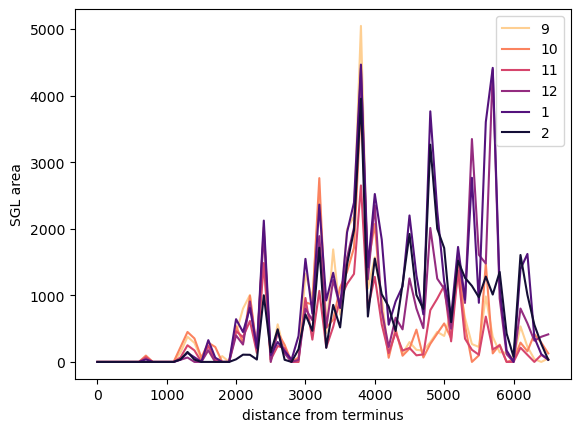

In [19]:
# quick viz
temp_df = all_df.reset_index()
xs = [ int(i.split("_")[0]) for i in temp_df.columns.values[1:]]
ms = temp_df['month']

# choose which months/order to use
ms = [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
ms = [9, 10, 11, 12, 1, 2,]
# ms = [3,4,5,6,7,8,9]

# iterate through a color ramp. new color for each interval
colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(ms))))
    
fig,axs = plt.subplots()

for m in ms:
    
    # grab which color we want to use
    color_to_use = next(colors_to_use)
    
    ys = temp_df[temp_df['month']==m].values[0][1:]
    axs.plot(xs,ys, c=color_to_use, label=m)
axs.legend()

axs.set_xlabel('distance from terminus')
axs.set_ylabel('SGL area')


Text(0, 0.5, 'SGL area')

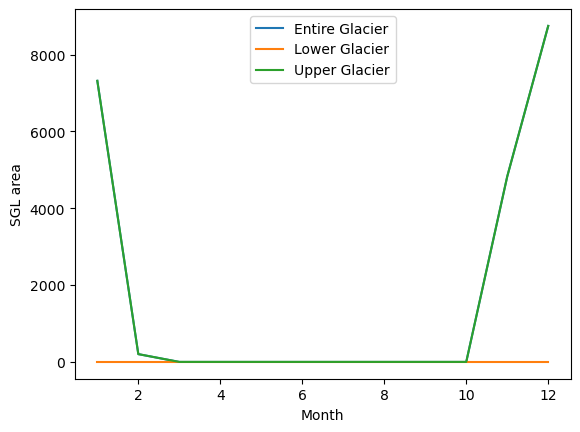

In [6]:
# quick viz, total lake are in each month
temp_df = all_df.reset_index()
half = int((temp_df.shape[1])/2)

# list of months for x-axis
ms = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# get total lake area in each month for y axis
areas_all = []
areas_upper = []
areas_lower = []
for m in ms:    
    areas_all.append(np.nansum(temp_df[temp_df['month']==m].values[0][1:]))
    areas_lower.append(np.nansum(temp_df[temp_df['month']==m].values[0][1:half]))
    areas_upper.append(np.nansum(temp_df[temp_df['month']==m].values[0][half:]))
    
fig,axs = plt.subplots()
axs.plot(ms, areas_all, label='Entire Glacier')
axs.plot(ms, areas_lower, label='Lower Glacier')
axs.plot(ms, areas_upper, label='Upper Glacier')

axs.legend()
axs.set_xlabel('Month')
axs.set_ylabel('SGL area')

In [7]:
half

15

In [8]:
[(m+6)%12+1 for m in ms]

[8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]